In [1]:
import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

import numpy as np
import scipy as sp
import torch
import h5py

import src.Optimizer as opt
import src.simulation_setup as setup

from loky import get_reusable_executor

In [2]:

buffer_test = "Experimental_data_CO_O_merged_test.hdf5"

const_dict, sim = setup.create_common_simulator(PATH, data_file=buffer_test)

Data Buffer:  /Users/joseafonso/Desktop/PlasmaDM/Buffer_Data/Experimental_data_CO_O_merged_test.hdf5
  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_F*O_S*r_40 - 0.02*CO_F*Odb_S*r_61 - 0.02*CO_F*Vdb_S*r_60 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_39 - CO_S*r_37 - CO_S*r_43 - CO_S*r_44 - CO_S*r_45 - CO_S*r_46 + r_32*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0)
  d[COdb_S]/dt = CO_F*Vdb_S*r_60 - COdb_S*O_F*r_62 - COdb_S*r_54 - COdb_S*r_55 - COdb_S*r_56 - COdb_S*r_57 - COdb_S*r_59 + Vdb_S*r_49
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_S*O_F*r_39 - 0.02*COdb_S*O_F*r_62 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_2

In [3]:

# 2. Define Parameters and Bounds
lower_bounds_dict = {
    'A_d': 1e-8, 'B_d': 1e-8, 'E_d': 0.0, 
    'SF_30': 1e-5, 'SF_31': 1e-5, 'SF_32': 1e-5, 'SF_33': 1e-5, 'SF_34': 1e-5, 'SF_35': 1e-5, 'SF_36': 1e-5, 'SF_37': 1e-5, 'SF_38': 1e-5, 'SF_39': 1e-5,
    'SF_49': 1e-5, 'SF_50': 1e-5, 'SF_51': 1e-5, 'SF_52': 1e-5, 'SF_53': 1e-5, 'SF_54': 1e-5, 'SF_55': 1e-5, 'SF_56': 1e-5, 'SF_57': 1e-5, 'SF_58': 1e-5, 'SF_59': 1e-5, 'SF_60': 1e-5, 'SF_61': 1e-5, 'SF_62': 1e-5,
    'Emin': 1.0, 'Ealpha': 2000
}

upper_bounds_dict = {
    'A_d': 5e-1, 'B_d': 1e-2, 'E_d': 30.0, 
    'SF_30': 1.0, 'SF_31': 1.0, 'SF_32': 1.0,  'SF_33': 1.0, 'SF_34': 1.0, 'SF_35': 1.0, 'SF_36': 1.0, 'SF_37': 1.0, 'SF_38': 1.0, 'SF_39': 1.0,
    'SF_49': 1.0, 'SF_50': 1.0, 'SF_51': 1.0, 'SF_52': 1.0, 'SF_53': 1.0, 'SF_54': 1.0, 'SF_55': 1.0, 'SF_56': 1.0, 'SF_57': 1.0, 'SF_58': 1.0, 'SF_59': 1.0, 'SF_60': 1.0, 'SF_61': 1.0, 'SF_62': 1.0,
    'Emin': 5.0, 'Ealpha': 5000
}

params_default_dict = {
    'A_d': 0.02634, 'B_d': 7.67e-4, 'E_d': 10.75, 
    'SF_30': 1.0, 'SF_31': 1.0, 'SF_32': 1e-2,  'SF_33': 1e-1, 'SF_34': 1e-1, 'SF_35': 1e-2, 'SF_36': 1e-1, 'SF_37': 1e-1, 'SF_38': 1e-1, 'SF_39': 1e-1,
    'SF_49': 1e-2, 'SF_50': 1.0, 'SF_51': 1.0, 'SF_52': 1.0, 'SF_53': 1e-1, 'SF_54': 1e-1, 'SF_55': 1.0, 'SF_56': 1.0, 'SF_57': 1.0, 'SF_58': 1e-1, 'SF_59': 1e-1, 'SF_60': 1e-2, 'SF_61': 1e-1, 'SF_62': 1e-1,
    'Emin': 3.4, 'Ealpha': 3000
}

lower_bounds = np.array(list(lower_bounds_dict.values()))
upper_bounds = np.array(list(upper_bounds_dict.values()))
params_default_init = np.array(list(params_default_dict.values()))
params_default_norm = (params_default_init - lower_bounds) * np.reciprocal(upper_bounds - lower_bounds)


def func_optimization(params_input, flag='numpy'):
    
    ##! normalize variables
    params = [0] * len(params_input)
    for idx, param in enumerate(params_input):
        params[idx] = lower_bounds[idx] + (upper_bounds[idx] - lower_bounds[idx]) * param
    
    A_d, B_d, E_d = params[0:3]
    SF_30, SF_31, SF_32, SF_33, SF_34, SF_35, SF_36, SF_37, SF_38, SF_39 = params[3:13]
    SF_49, SF_50, SF_51, SF_52, SF_53, SF_54, SF_55, SF_56, SF_57, SF_58, SF_59, SF_60, SF_61, SF_62 = params[13:27]
    Emin, Ealpha = params[27:]
    
    if flag=='numpy':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * np.exp(E_d/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * torch.exp(E_d/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 16, "rate": None, "model_dict": {"Emin": Emin}},
    {"id": 18, "rate": None, "model_dict": {"Emin": Emin}},
    
    {"id": 31, "rate": None, "model_dict": {"SF": SF_31, "nu_d": nu_d_mod}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_30}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_32}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_33}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_34}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_35}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_36}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_37}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_38}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_39}},
    
    {"id": 44, "rate": None, "model_dict": {"Emin": Emin}},
    
    {"id": 49, "rate": None, "model_dict": {"SF": SF_49}},
    {"id": 50, "rate": None, "model_dict": {"SF": SF_50, "Ealpha": Ealpha}},
    {"id": 51, "rate": None, "model_dict": {"SF": SF_51, "Ealpha": Ealpha}},
    {"id": 52, "rate": None, "model_dict": {"SF": SF_52, "Ealpha": Ealpha}},
    {"id": 53, "rate": None, "model_dict": {"SF": SF_53, "Ealpha": Ealpha}},
    {"id": 54, "rate": None, "model_dict": {"SF": SF_54, "Ealpha": Ealpha}},
    {"id": 55, "rate": None, "model_dict": {"SF": SF_55, "Ealpha": Ealpha}},
    {"id": 56, "rate": None, "model_dict": {"SF": SF_56, "Ealpha": Ealpha}},
    {"id": 57, "rate": None, "model_dict": {"SF": SF_57, "Ealpha": Ealpha}},
    {"id": 58, "rate": None, "model_dict": {"SF": SF_58, "Ealpha": Ealpha}},
    {"id": 59, "rate": None, "model_dict": {"SF": SF_59, "Ealpha": Ealpha}},
    {"id": 60, "rate": None, "model_dict": {"SF": SF_60}},
    {"id": 61, "rate": None, "model_dict": {"SF": SF_61}},
    {"id": 62, "rate": None, "model_dict": {"SF": SF_62}}
    ]
    
    return dict_mod_vec

def loss_function(exp, teo, flag='numpy'):
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")


# 4. Instantiate and Run Optimizer
optimizer = opt.Optimizer(sim, 
                        lambda params: func_optimization(params, 'numpy'), 
                        lambda exp, teo: loss_function(exp, teo, 'numpy')
                        )


def Phi_loss(x):
    loss_val = optimizer.objective_function(x)
    return loss_val


def get_evaluation_indices(losses, min_ratio, max_evals):
    # Ensure input is a numpy array
    losses = np.asarray(losses)
    
    selected_indices = []
    last_val = np.inf 
    
    for i, current_loss in enumerate(losses):
        if len(selected_indices) >= max_evals:
            break
            
        # Check improvement ratio
        # (last_val - current_loss) / last_val >= min_ratio
        # Rearranged to avoid division by zero:
        if (last_val - current_loss) >= (min_ratio * last_val):
            selected_indices.append(i)
            last_val = current_loss

    return np.array(selected_indices)

In [4]:

### read data 

# file_train = "../study_opt_local/results/results_Powell_train_V4.h5"
# file_test =  "results/results_Powell_test_V4.h5"

file_train = "../study_opt_hierarchical/results/results_hier2_train_V4.h5"
file_test =  "results/results_hier2_test_V4.h5"


with h5py.File(file_train, "r") as f:
    best_loss = f['best_loss'][:]
    iters = f['iters'][:]
    params = f['best_params'][:]



In [5]:
print(params)
print(params.shape)
print(best_loss)


[[0.05267998 0.07669908 0.35833333 ... 0.099991   0.6        0.33333333]
 [0.05267998 0.07669908 0.35833333 ... 0.099991   0.6        0.33333333]
 [0.05267951 0.07670217 0.35833383 ... 0.0999917  0.5999984  0.33333536]
 ...
 [0.07339103 0.11634415 0.51358946 ... 0.22589072 0.42391236 0.40754174]
 [0.07339103 0.11634415 0.51358946 ... 0.22589072 0.42391236 0.40754174]
 [0.07339103 0.11634415 0.51358946 ... 0.22589072 0.42391236 0.40754174]]
(989, 29)
[7.83741935e+02 7.83741935e+02 7.83647723e+02 7.83647723e+02
 7.83647723e+02 7.83647723e+02 7.83647723e+02 7.83647723e+02
 7.83647723e+02 7.83647723e+02 7.83647723e+02 7.83647723e+02
 7.83647723e+02 7.83647723e+02 3.71888507e-01 3.71888507e-01
 3.71888507e-01 3.71888507e-01 3.71888507e-01 2.54363700e-01
 2.54363700e-01 2.31631705e-01 2.31631705e-01 2.28094757e-01
 2.28060162e-01 2.28047232e-01 2.28046963e-01 2.28046963e-01
 2.28046963e-01 2.28046963e-01 2.28046963e-01 2.28046963e-01
 2.28046963e-01 2.28046963e-01 2.28046963e-01 2.28046963e-

In [6]:


test_idx_vec = get_evaluation_indices(best_loss, min_ratio=0.001, max_evals=100)


In [7]:
print(test_idx_vec)
print(best_loss[test_idx_vec])
print(params[test_idx_vec,:].shape)

[  0  14  19  21  23  92  93  97  99 102 103 104 106 107 108 109 111 112
 113 114 116 117 118 119 120 157 158 162 163 165 168 169 172 173 174 175
 177 178 179 180 181 182 186 187 188 189 191 192 193 196 197 210 246 249
 284 295 296 300 303 306 308 309 312 315 318 321 324 346 347 351 354 355
 358 359 361 362 365 367 368 370 447 507 519 543 575 580 584 589 592 596
 598 601 603 604 607 611 706 727 740 743]
[7.83741935e+02 3.71888507e-01 2.54363700e-01 2.31631705e-01
 2.28094757e-01 2.27790040e-01 2.27517016e-01 2.27052881e-01
 2.26311141e-01 2.25317898e-01 2.25062208e-01 2.23770619e-01
 2.23038256e-01 2.21142561e-01 2.20608541e-01 2.17418618e-01
 2.15802064e-01 2.11012700e-01 2.08637367e-01 1.98189947e-01
 1.93869641e-01 1.74941199e-01 1.62435656e-01 1.04649483e-01
 1.00434204e-01 1.00288496e-01 1.00158982e-01 9.99496357e-02
 9.97271584e-02 9.94078570e-02 9.89651000e-02 9.83976155e-02
 9.81062975e-02 9.75480907e-02 9.72120390e-02 9.62432448e-02
 9.57007340e-02 9.46012282e-02 9.44469273e-0

In [8]:
if __name__ == "__main__":
    
    params_subset = params[test_idx_vec,:]
    executor = get_reusable_executor(max_workers=8, timeout=2)
    results = np.array(list(executor.map(Phi_loss, params_subset)))

In [9]:
print(results)

[5.65611219e+02 2.35363860e-01 2.03222696e-01 1.74352897e-01
 1.65910257e-01 1.65062298e-01 1.64966042e-01 1.64704077e-01
 1.64389281e-01 1.64080691e-01 1.63892142e-01 1.63319100e-01
 1.63011511e-01 1.62146373e-01 1.62037747e-01 1.60669987e-01
 1.59748178e-01 1.57454671e-01 1.56438102e-01 1.51276665e-01
 1.49106910e-01 1.38820131e-01 1.31247385e-01 8.99360431e-02
 8.65211735e-02 8.63998832e-02 8.63845761e-02 8.63395552e-02
 8.62658932e-02 8.62016288e-02 8.61491656e-02 8.60521567e-02
 8.59502930e-02 8.59230971e-02 8.57987651e-02 8.56976986e-02
 8.55223458e-02 8.54780431e-02 8.57742990e-02 8.65687201e-02
 8.53068901e-02 8.52820563e-02 8.84897089e-02 9.03019196e-02
 8.82795990e-02 8.89910024e-02 8.68437528e-02 8.88791091e-02
 9.22966957e-02 8.85005598e-02 9.18499275e-02 9.03127144e-02
 8.92102616e-02 8.89382202e-02 8.85828022e-02 8.83798346e-02
 8.81022004e-02 8.76310581e-02 8.71983590e-02 8.64104175e-02
 8.62231243e-02 8.53094712e-02 8.40499644e-02 8.21436642e-02
 7.97613120e-02 7.690782

In [10]:

##* write data

best_loss_train = best_loss[test_idx_vec]
iters_test = iters[test_idx_vec]
loss_test = results
params_test = params_subset


with h5py.File(file_test, "w") as f:
    f.create_dataset("best_loss_train", data=best_loss_train)
    f.create_dataset("iters", data=iters_test)
    f.create_dataset("loss_test", data=loss_test)
    f.create_dataset("params_test", data=params_test)



In [11]:
print(loss_test)
print(best_loss_train)

[5.65611219e+02 2.35363860e-01 2.03222696e-01 1.74352897e-01
 1.65910257e-01 1.65062298e-01 1.64966042e-01 1.64704077e-01
 1.64389281e-01 1.64080691e-01 1.63892142e-01 1.63319100e-01
 1.63011511e-01 1.62146373e-01 1.62037747e-01 1.60669987e-01
 1.59748178e-01 1.57454671e-01 1.56438102e-01 1.51276665e-01
 1.49106910e-01 1.38820131e-01 1.31247385e-01 8.99360431e-02
 8.65211735e-02 8.63998832e-02 8.63845761e-02 8.63395552e-02
 8.62658932e-02 8.62016288e-02 8.61491656e-02 8.60521567e-02
 8.59502930e-02 8.59230971e-02 8.57987651e-02 8.56976986e-02
 8.55223458e-02 8.54780431e-02 8.57742990e-02 8.65687201e-02
 8.53068901e-02 8.52820563e-02 8.84897089e-02 9.03019196e-02
 8.82795990e-02 8.89910024e-02 8.68437528e-02 8.88791091e-02
 9.22966957e-02 8.85005598e-02 9.18499275e-02 9.03127144e-02
 8.92102616e-02 8.89382202e-02 8.85828022e-02 8.83798346e-02
 8.81022004e-02 8.76310581e-02 8.71983590e-02 8.64104175e-02
 8.62231243e-02 8.53094712e-02 8.40499644e-02 8.21436642e-02
 7.97613120e-02 7.690782

/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_40824/3037644842.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 1.0)


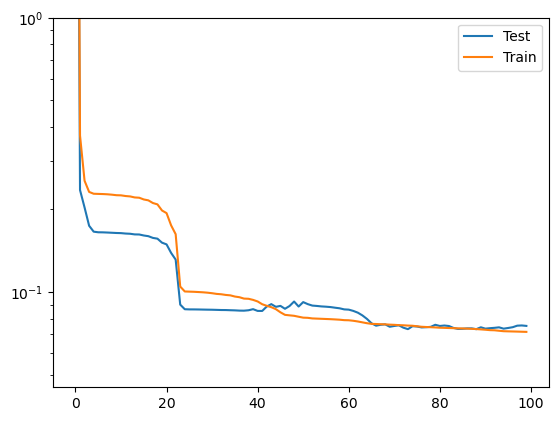

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_test, label="Test")
plt.plot(best_loss_train, label="Train")
plt.yscale('log')
plt.ylim(0.0, 1.0)
plt.legend()